# Rreproduce Training.ipynb (tensorflow implimentation in )

In [2]:
import torch
import numpy as np

import sys
import itertools
import os

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
sys.path.append('src')
from src.model import GMVAE

matplotlib.rcParams.update({'font.size': 24})

In [35]:
import importlib
import src.model
importlib.reload(src.model)
from src.model import GMVAE

In [6]:
readdir = '../data/'
modeldir = 'models/'

In [7]:
# Load data
data = np.load(readdir + "traj_mb.npy")

data = torch.tensor(data.reshape(len(data)*10000, 2), dtype=torch.float32)
#dataset = load_and_mix_data_nolabel(data=data, test_ratio=0.01)

In [36]:
# Hyperparameters
k, n_x, n_z, n_epochs = 5, 2, 1, 401
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.05
batch_size = 5000
lr = 1e-4

model_path = modeldir + 'test1/' 


In [31]:
lengths = [int(p * len(data)) for p in [0.99,0.01]]
tr,v = torch.utils.data.random_split(data,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
trainloader = torch.utils.data.DataLoader(data,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(data,batch_size=batch_size,sampler=val_sampler)

In [6]:
len(valloader.sampler)

3000

# Parameters trained with Tensorflow code

In [11]:
# Read parameters from the final results with tensorflow model
v = []
with open('../tf/original_5_1_401_0.05_5000/v.txt', 'r') as f:
    for line in f.readlines():
        v.append(line)
value = []
for i in range(len(v)):
    value.append(np.load('../tf/original_5_1_401_0.05_5000/' +str(i) + '.npy'))

The conclusion is that the pyTorch model worked, but there are convergence issues.

Model 0 (random initialization) converged to a local minimum with bad performance.

Model 1 (with some parameters initialized from the tensorflow training results) converged very slowly.

Model 2 (with more parameters initialized from the tensorflow training results) performs well and give similar results to tensorflow training.

In [192]:
model0 = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

In [193]:
model0.train_model(trainloader, valloader, 201)

    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  4.50e+00,  1.61e+00,  4.48e+00,         0
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  2.69e+00,  1.61e+00,  2.62e+00,        50
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  2.69e+00,  1.61e+00,  2.62e+00,       100
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  2.69e+00,  1.61e+00,  2.62e+00,       150
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  2.69e+00,  1.61e+00,  2.62e+00,       200


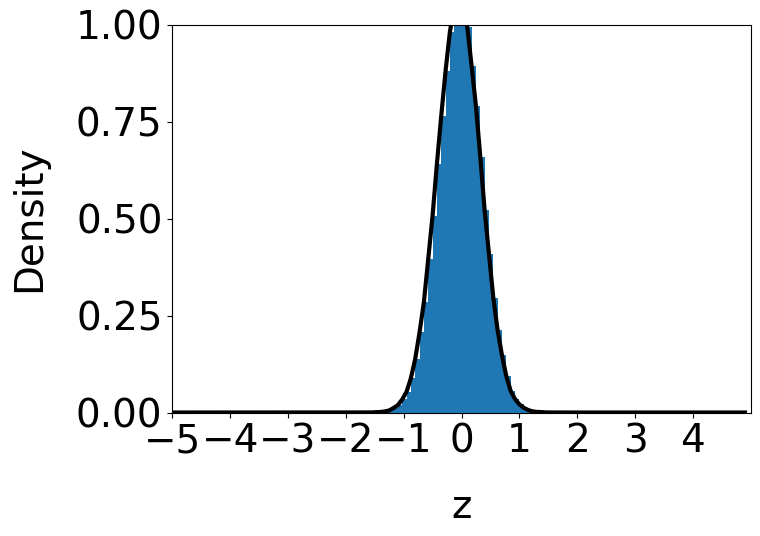

In [196]:
with torch.no_grad():
    qy = model0.encode_y(data)
    y_pred = np.argmax(qy, axis=1)
    z = model0.encode_z(data)
z = z.numpy().reshape(len(z),)
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
_ = plt.hist(z, bins= np.arange(-5, 5, 0.075), density=True)
ah = np.histogram(z, bins= np.arange(-5, 5, 0.075), density=True)
plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
plt.ylabel('Density', labelpad=20)
plt.xlabel('z', labelpad=20)
plt.xticks(np.arange(-5, 5))
plt.xlim([-5,5])
plt.ylim([0, 1])
titlename = 'z_histograms_line'
plt.tight_layout()

In [189]:
model1 = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

In [ ]:
# Parameters of qy and pz are not used in the model

In [190]:
i = 4
model1.ytransform.fc_layers.weight.data = torch.tensor(value[i]).T
i+=1
model1.ytransform.fc_layers.bias.data = torch.tensor(value[i]) 
i+=1
model1.qz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
model1.qz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
model1.qz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
model1.qz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3

model1.pz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
model1.pz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
model1.pz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
model1.pz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3

In [191]:
model1.train_model(trainloader, valloader, 401)

    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.61e+00,  1.29e+01,  1.61e+00,  1.23e+01,         0
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  4.03e-01,  1.48e+00,  3.80e-01,  1.34e+00,        50
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.43e-01,  1.09e+00,  2.27e-01,  1.02e+00,       100
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.28e-01,  8.80e-01,  2.10e-01,  8.06e-01,       150
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.22e-01,  7.82e-01,  2.04e-01,  7.10e-01,       200
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.16e-01,  7.39e-01,  1.98e-01,  6.69e-01,       250
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.03e-01,  6.67e-01,  1.87e-01,  6.01e-01,       300
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.65e-01,  5.60e-01,  1.52e-01,  4.95e-01,       350
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.29e-01,  4.83e-01,  1.18e-01,  4.25e-01,       400


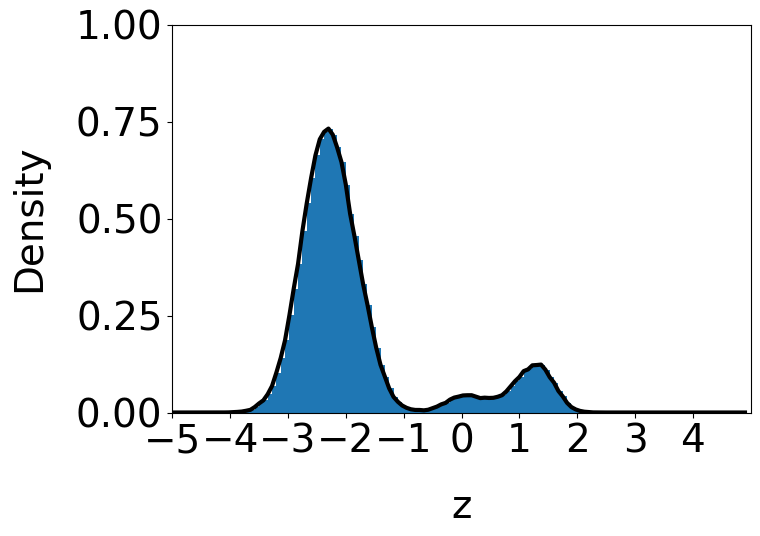

In [194]:
with torch.no_grad():
    qy = model1.encode_y(data)
    y_pred = np.argmax(qy, axis=1)
    z = model1.encode_z(data)
z = z.numpy().reshape(len(z),)
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
_ = plt.hist(z, bins= np.arange(-5, 5, 0.075), density=True)
ah = np.histogram(z, bins= np.arange(-5, 5, 0.075), density=True)
plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
plt.ylabel('Density', labelpad=20)
plt.xlabel('z', labelpad=20)
plt.xticks(np.arange(-5, 5))
plt.xlim([-5,5])
plt.ylim([0, 1])
titlename = 'z_histograms_line'
plt.tight_layout()


In [26]:


if not os.path.exists(model_path):
    os.makedirs(model_path)

    
mymodel = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

#mymodel.train_model(trainloader, valloader, 401)

In [27]:
i = 0
mymodel.qy_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T    
i+=1
mymodel.qy_graph.fc_layers[0].bias.data = torch.tensor(value[i]) 
i+=1
mymodel.qy_graph.fc_layers[1].weight.data = torch.tensor(value[i]).T
i+=1
mymodel.qy_graph.fc_layers[1].bias.data = torch.tensor(value[i])
i+=1

In [28]:
mymodel.ytransform.fc_layers.weight.data = torch.tensor(value[i]).T
i+=1
mymodel.ytransform.fc_layers.bias.data = torch.tensor(value[i]) 
i+=1
mymodel.qz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
mymodel.qz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
mymodel.qz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
mymodel.qz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3


In [29]:
mymodel.pz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
mymodel.pz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
mymodel.pz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
mymodel.pz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3

In [171]:
# Parameters notinitialized to tensorflow traing results
'''
mymodel.px_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
mymodel.px_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1

mymodel.px_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
mymodel.px_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3
'''

In [32]:
mymodel.train_model(trainloader, valloader, 401)

    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.20e-01,  6.19e+00,  1.24e-01,  5.08e+00,         0
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.29e-01, -1.06e-01,  1.29e-01, -4.97e-02,        50
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.27e-01, -2.04e-01,  1.27e-01, -1.56e-01,       100
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.37e-01, -3.04e-01,  1.39e-01, -2.71e-01,       150
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.24e-01, -3.20e-01,  1.23e-01, -2.84e-01,       200
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.13e-01, -3.36e-01,  1.15e-01, -3.06e-01,       250
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.05e-01, -3.40e-01,  1.07e-01, -3.10e-01,       300
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  9.75e-02, -3.23e-01,  1.01e-01, -2.91e-01,       350
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  9.41e-02, -3.34e-01,  9.62e-02, -3.04e-01,       400


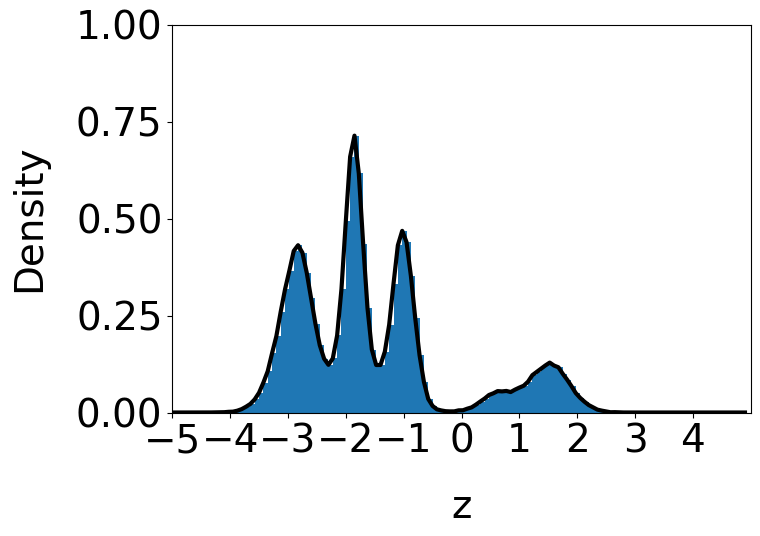

In [34]:
with torch.no_grad():
    qy = mymodel.encode_y(data)
    y_pred = np.argmax(qy, axis=1)
    z = mymodel.encode_z(data)
z = z.numpy().reshape(len(z),)
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
_ = plt.hist(z, bins= np.arange(-5, 5, 0.075), density=True)
ah = np.histogram(z, bins= np.arange(-5, 5, 0.075), density=True)
plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
plt.ylabel('Density', labelpad=20)
plt.xlabel('z', labelpad=20)
plt.xticks(np.arange(-5, 5))
plt.xlim([-5,5])
plt.ylim([0, 1])
titlename = 'z_histograms_line'
plt.tight_layout()


# Confirming the loss function is correct

In [9]:
tfmodel = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

In [17]:
i = 0
tfmodel.qy_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T    
i+=1
tfmodel.qy_graph.fc_layers[0].bias.data = torch.tensor(value[i]) 
i+=1
tfmodel.qy_graph.fc_layers[1].weight.data = torch.tensor(value[i]).T
i+=1
tfmodel.qy_graph.fc_layers[1].bias.data = torch.tensor(value[i])
i+=1
tfmodel.ytransform.fc_layers.weight.data = torch.tensor(value[i]).T
i+=1
tfmodel.ytransform.fc_layers.bias.data = torch.tensor(value[i]) 
i+=1
tfmodel.qz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
tfmodel.qz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
tfmodel.qz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
tfmodel.qz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3
tfmodel.pz_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
tfmodel.pz_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
tfmodel.pz_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
tfmodel.pz_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3
tfmodel.px_graph.fc_layers[0].weight.data = torch.tensor(value[i]).T
i+=1
tfmodel.px_graph.fc_layers[0].bias.data = torch.tensor(value[i])
i+=1
tfmodel.px_graph.fc_layers[1].weight.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=1).T
i+=1
tfmodel.px_graph.fc_layers[1].bias.data = torch.cat((torch.tensor(value[i]), torch.tensor(value[i+2])), dim=0)
i+=3


In [24]:
with torch.no_grad():
    loss, nent = tfmodel.loss(data, *tfmodel(data))
    print(f'nent = {nent:.3f}, loss = {loss:.3f}')

nent = 0.119, loss = -0.191
